Using transfer learning , perform image classification of yoga poses.  
Pretrained model : MobileNet

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import cv2

In [3]:
from keras.preprocessing.image import ImageDataGenerator

mobile_net_preprocess = tf.keras.applications.mobilenet.preprocess_input
##
image_path = "../input/yoga-poses-cgi/train"
test_path = "../input/yoga-poses-cgi/test"
##

train_data_gen = ImageDataGenerator(preprocessing_function = mobile_net_preprocess, validation_split = 0.2)
test_data_gen = ImageDataGenerator(preprocessing_function = mobile_net_preprocess)


##
train_ds = train_data_gen.flow_from_directory(image_path , target_size=(224, 224),
        batch_size=32 ,subset = 'training' , seed = 123 , class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')
val_ds = train_data_gen.flow_from_directory(image_path , target_size=(224, 224),
        batch_size=32 ,subset = 'validation' , seed = 123 , class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')

test_ds = test_data_gen.flow_from_directory(test_path ,target_size=(224, 224),
        batch_size=32 ,class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')

Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 495 images belonging to 5 classes.


In [4]:
labels = (train_ds.class_indices)
labels_dict = dict((v,k) for k,v in labels.items())
labels_dict

{0: 'chair', 1: 'cobra', 2: 'dog', 3: 'tree', 4: 'warrior'}

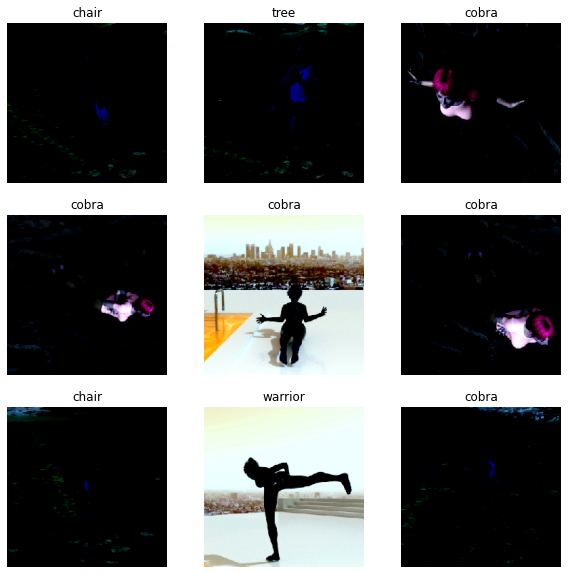

In [5]:
## visualize train set images
image_batch, label_batch = next(iter(train_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")

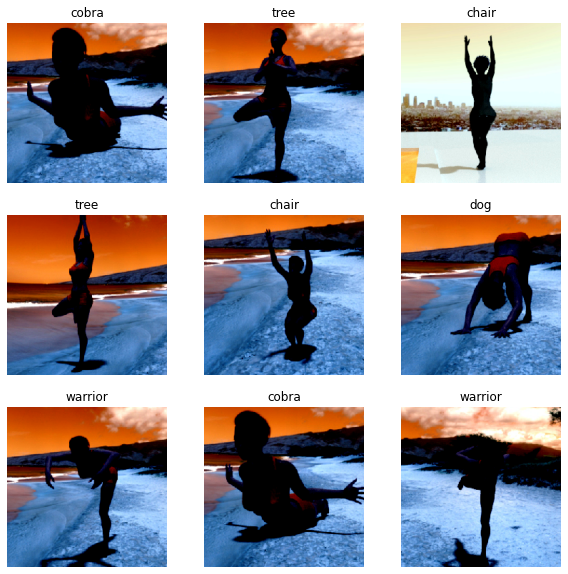

In [12]:
## visualize validation images 
image_batch, label_batch = next(iter(val_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(image_batch[i])
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")

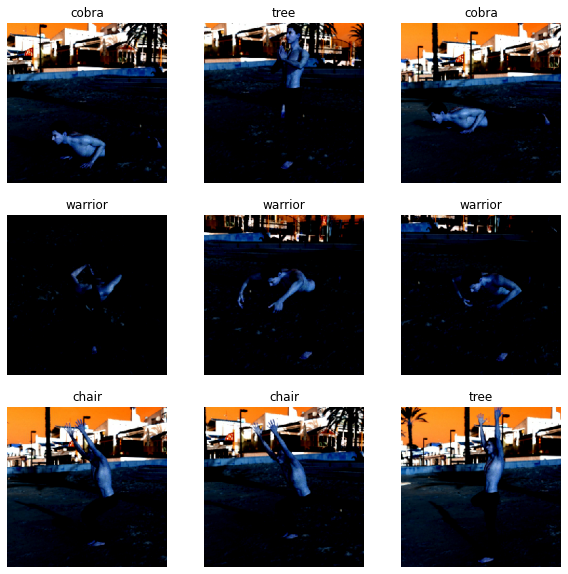

In [13]:
## visualize test images 
image_batch, label_batch = next(iter(test_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(image_batch[i])
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 4,283,589
Trainable params: 1,054,725
Non-trainable params: 3,228,864
_________________________________________________________________
CPU times: user 36.2 s, sys: 2.01 s, total: 38.3 s
Wall time: 41.5 s
25/25 [==============================] - 2s 73ms/step - loss: 0.4123 - accuracy: 0.8424
Test image accuracy :0.842424213886261
Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.45      0.62        75
       cobra      

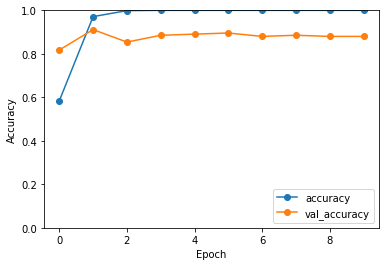

In [39]:
## Transfer learning with MobileNet . 

base_Net = tf.keras.applications.MobileNet(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(1024))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

%time history = model_Net.fit(train_ds, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_ds,validation_steps=STEP_SIZE_VALID, epochs=10, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds, steps = STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_mobilenet_1')

## for test data set , check the classification report.

loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])

for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x, steps = STEP_SIZE_TEST), axis = -1)
    predicted = np.concatenate([predicted , predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
                            
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5125      
Total params: 4,283,589
Trainable params: 1,054,725
Non-trainable params: 3,228,864
_________________________________________________________________
CPU times: user 35.2 s, sys: 2.47 s, total: 37.6 s
Wall time: 40.4 s
25/25 [==============================] - 2s 72ms/step - loss: 0.6062 - accuracy: 0.7879
Test image accuracy :0.7878788113594055
Classification Report for new test im

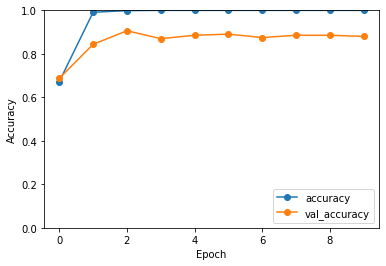

In [40]:
## Transfer learning with Mobilenet  With drop out 

base_Net = tf.keras.applications.MobileNet(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(1024))
model_Net.add(tf.keras.layers.Dropout(0.2))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

%time history = model_Net.fit(train_ds, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_ds,validation_steps=STEP_SIZE_VALID, epochs=10, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds, steps = STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_mobilenet_2')

## for test data set , check the classification report.

loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])

for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x, steps = STEP_SIZE_TEST), axis = -1)
    predicted = np.concatenate([predicted , predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
                            
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 3,756,229
Trainable params: 527,365
Non-trainable params: 3,228,864
_________________________________________________________________
CPU times: user 35.8 s, sys: 2.17 s, total: 37.9 s
Wall time: 39.8 s
25/25 [==============================] - 2s 71ms/step - loss: 0.2251 - accuracy: 0.9192
Test image accuracy :0.9191918969154358
Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.72      0.84        76
       cobra       

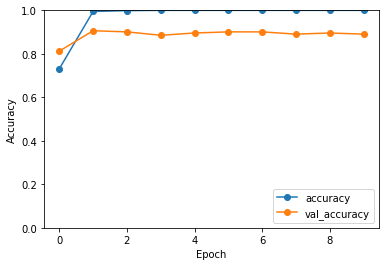

In [41]:
## Transfer learning with MobileNet with 512 dense neurons

base_Net = tf.keras.applications.MobileNet(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(512))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

# Training the CNN on the Train data and evaluating it on the val data

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

%time history = model_Net.fit(train_ds, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_ds,validation_steps=STEP_SIZE_VALID, epochs=10, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds, steps=STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_mobilenet_3')
##
## print classification report 
loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])

for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x, steps = STEP_SIZE_TEST), axis = -1)
    predicted = np.concatenate([predicted , predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
                            
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Using the best model above, test on the new images of yoga poses .

In [42]:
## read in all the new test yoga poses and check the prediction 
test_path_2 = "../input/new-yoga-poses/yoga_test_data"
test_ds_2 = test_data_gen.flow_from_directory(test_path_2 ,target_size=(224, 224),
        batch_size=32 ,class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')
##

Found 26 images belonging to 5 classes.


In [44]:
## load the model 
model = tf.keras.models.load_model('./model_mobilenet_1')
##
loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.50      0.67         6
       cobra       1.00      0.80      0.89         5
         dog       0.56      1.00      0.71         5
        tree       0.33      0.60      0.43         5
     warrior       0.00      0.00      0.00         5

    accuracy                           0.58        26
   macro avg       0.58      0.58      0.54        26
weighted avg       0.59      0.58      0.54        26



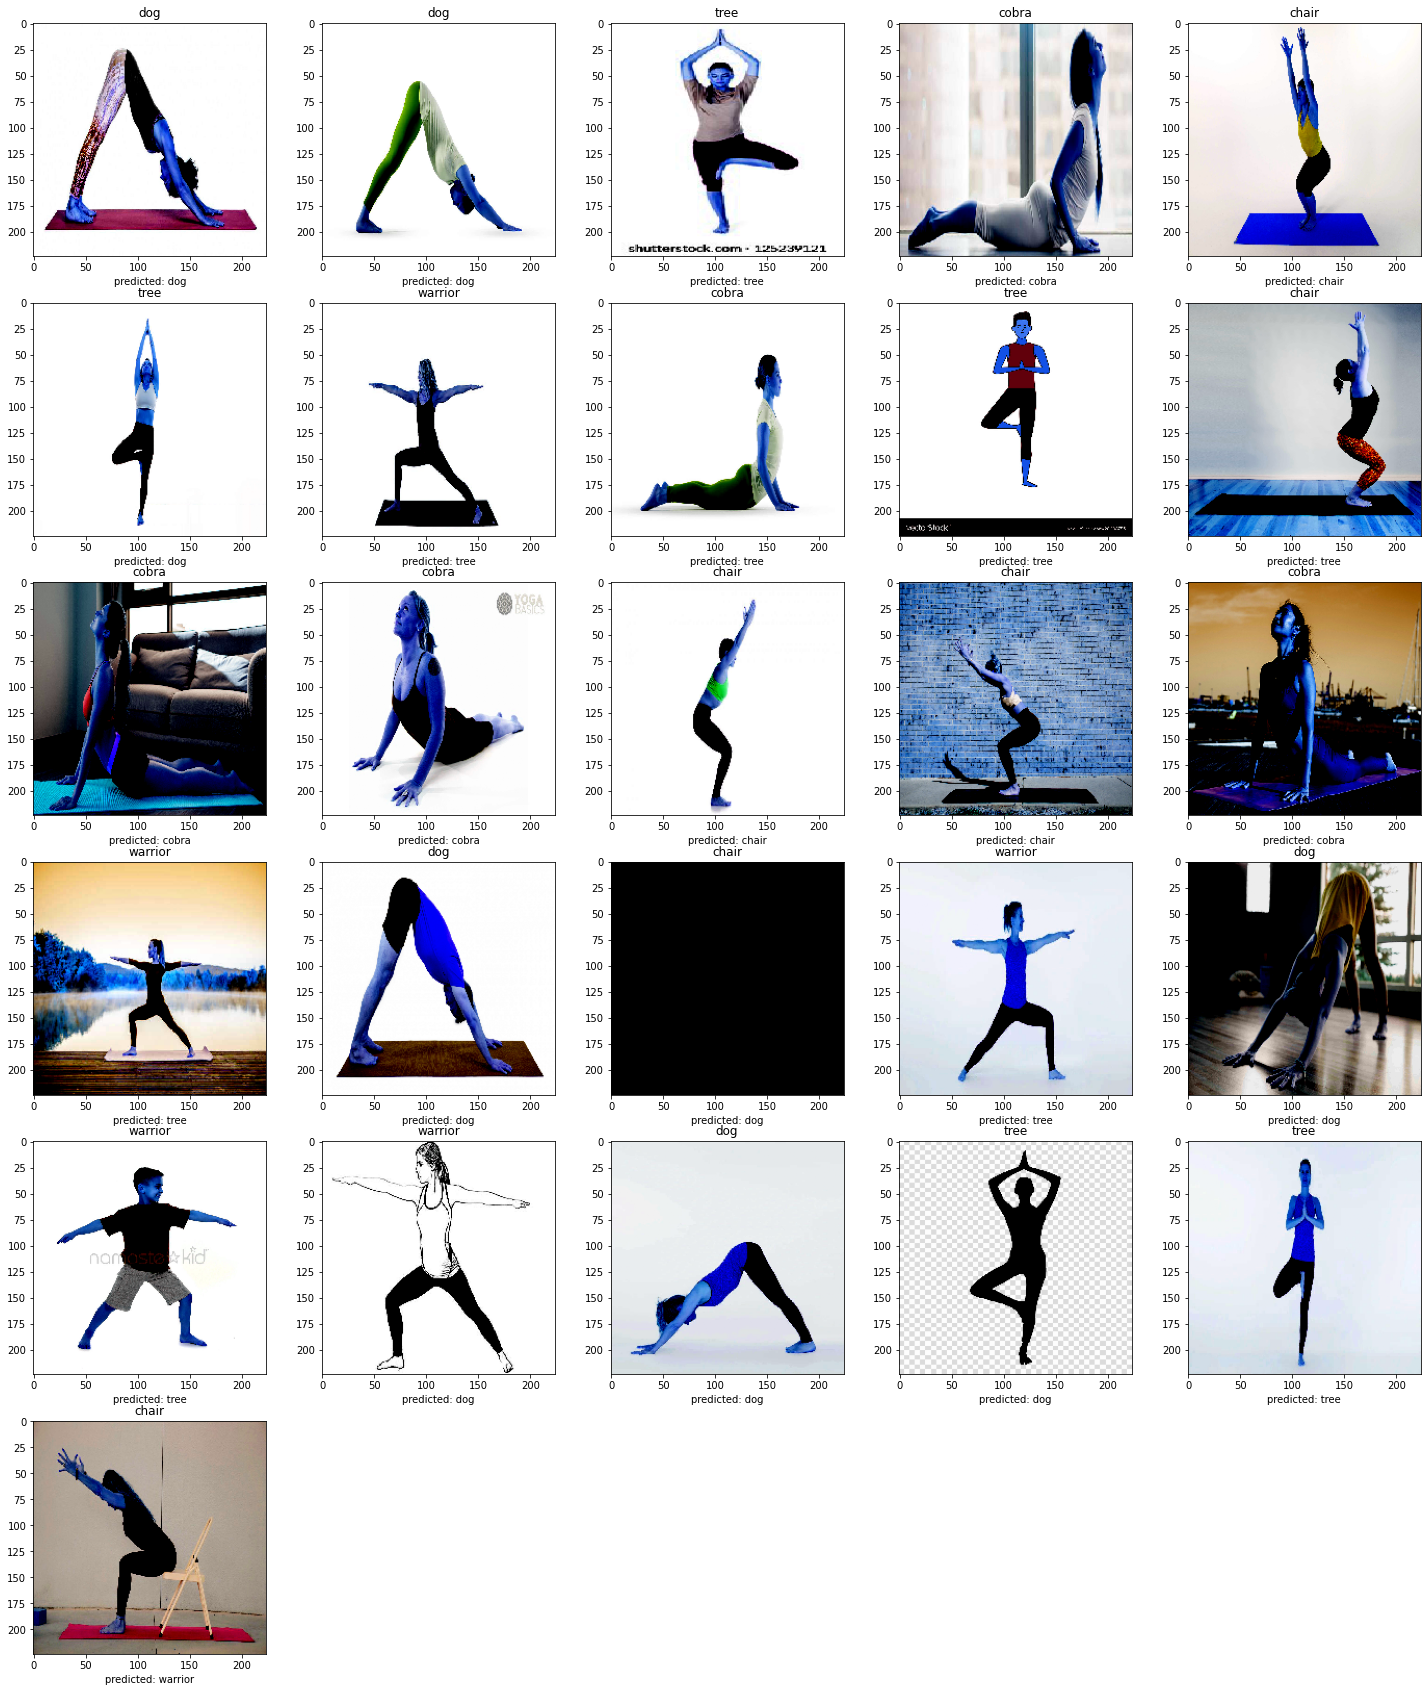

In [45]:
## visualize images with their prediction 
image_batch, label_batch = test_ds_2.next()
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(25, 30))
for i in range(26):
    ax = plt.subplot(6, 5, i + 1)
    #plt.imshow(image_batch[i])
    plt.imshow(cv2.cvtColor(img[0][i], cv2.COLOR_BGR2RGB))
    label = actual[i]
    pred_label = predicted[i]
    name = labels_dict[label]
    plt.title(name)
    plt.xlabel('predicted: ' + labels_dict[pred_label])
    #plt.axis("off")

In [46]:
## load the model 
model = tf.keras.models.load_model('./model_mobilenet_2')
##
loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.33      0.50         6
       cobra       1.00      0.40      0.57         5
         dog       0.36      1.00      0.53         5
        tree       0.33      0.40      0.36         5
     warrior       0.00      0.00      0.00         5

    accuracy                           0.42        26
   macro avg       0.54      0.43      0.39        26
weighted avg       0.56      0.42      0.40        26



In [48]:
## load the model 
model = tf.keras.models.load_model('./model_mobilenet_3')
##
loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.50      0.67         6
       cobra       1.00      0.80      0.89         5
         dog       0.57      0.80      0.67         5
        tree       0.40      0.80      0.53         5
     warrior       0.00      0.00      0.00         5

    accuracy                           0.58        26
   macro avg       0.59      0.58      0.55        26
weighted avg       0.61      0.58      0.56        26



Summary :

Transfer learning with ResNet50 gives best test image accuracy of 0.91.
On the new images downloaded from the internet , which consists of non CGI origin , the accuracy is 0.58.